In [ ]:
import pandas as pd

chunk_size = 1000

file_path = '../replay_data_public.WOE.PremierDraft.csv'

# Initialize a dictionary to store land-miss patterns and win counts
land_miss_patterns = {}

# Function to check land plays for a single player and classify based on missed lands
def classify_land_misses(row, player_prefix, max_turns):
    pattern = []
    for i in range(1, min(max_turns + 1, 9)):  # Check up to max_turns or 9 turns, whichever is smaller
        if pd.isna(row[f'{player_prefix}_turn_{i}_lands_played']):
            pattern.append(f'missed_turn_{i}')
    return ', '.join(pattern) if pattern else 'No land missed'

# Create an iterator to read in chunks
chunk_iter = pd.read_csv(file_path, chunksize=chunk_size)

# Variables for tests
total_rows = 0
missed_only_turn_3_count = 0

# Process each chunk
for chunk in chunk_iter:
    total_rows += len(chunk)
    for index, row in chunk.iterrows():
        max_turns = row['num_turns'] - 1  # Determine the max turns for this game
        # Classify for user
        user_pattern = classify_land_misses(row, 'user', max_turns)
        if user_pattern not in land_miss_patterns:
            land_miss_patterns[user_pattern] = {'wins': 0, 'total': 0}
        land_miss_patterns[user_pattern]['total'] += 1
        if row['won']:
            land_miss_patterns[user_pattern]['wins'] += 1

        # Classify for opponent
        oppo_pattern = classify_land_misses(row, 'oppo', max_turns)
        if oppo_pattern not in land_miss_patterns:
            land_miss_patterns[oppo_pattern] = {'wins': 0, 'total': 0}
        land_miss_patterns[oppo_pattern]['total'] += 1
        if not row['won']:
            land_miss_patterns[oppo_pattern]['wins'] += 1
            
        # Test 2: Count occurrences of missing only turn 3 land drop
        for player_prefix in ['user', 'oppo']:
            missed_turns = [i for i in range(1, 6) if pd.isna(row[f'{player_prefix}_turn_{i}_lands_played'])]
            if missed_turns == [3]:  # Check if the only missed turn is turn 3
                missed_only_turn_3_count += 1

# Calculate win rates for each pattern
for pattern, data in land_miss_patterns.items():
    data['win_rate'] = data['wins'] / data['total'] if data['total'] > 0 else 0

# Test 1: Compare sum of totals with twice the number of rows in CSV
total_pattern_counts = sum(data['total'] for data in land_miss_patterns.values())
print(f"Total pattern counts: {total_pattern_counts}, Expected: {2 * total_rows}")
# Test 2: results
print(f"Total occurrences of a player missing only the turn 3 land drop: {missed_only_turn_3_count}")

pd.set_option('display.max_rows', None)  # Set to None to display all rows

# Convert the results to a DataFrame for display
results_df = pd.DataFrame.from_dict(land_miss_patterns, orient='index')
print(results_df)

pd.reset_option('display.max_rows')

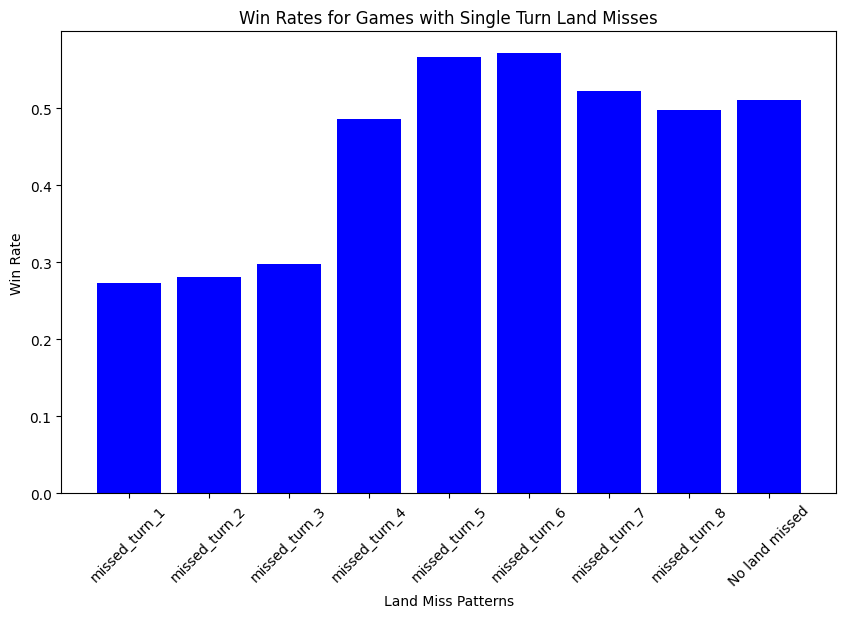

In [5]:
import matplotlib.pyplot as plt

# Define the specific patterns in order
ordered_patterns = [f'missed_turn_{i}' for i in range(1, 9)] + ['No land missed']

# Filter and reorder the DataFrame
filtered_ordered_results_df = results_df.loc[ordered_patterns]

# Plotting
plt.figure(figsize=(10, 6))  
plt.bar(filtered_ordered_results_df.index, filtered_ordered_results_df['win_rate'], color='blue')
plt.xlabel('Land Miss Patterns')
plt.ylabel('Win Rate')
plt.title('Win Rates for Games with Single Turn Land Misses')
plt.xticks(rotation=45) 

plt.show()



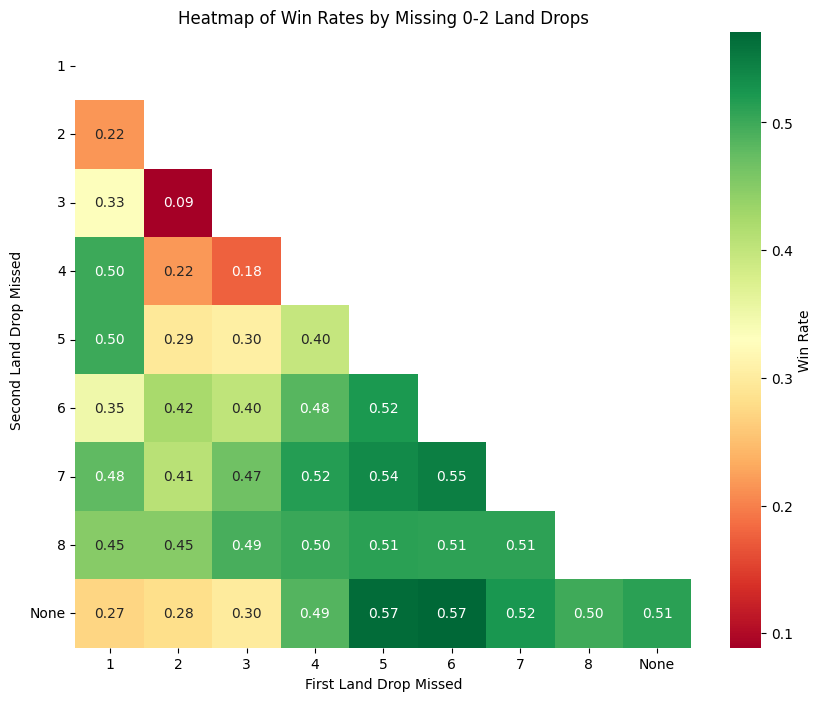

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a 9x9 grid with NaN values for the heatmap
heatmap_data = np.full((9, 9), np.nan, dtype=float)


# Populate the grid with win rates
for pattern, row in results_df.iterrows():
    # Check if the pattern is 'No land missed', which is equivalent to no missed lands
    if pattern == 'No land missed':
        heatmap_data[8, 8] = row['win_rate']  # Set the value for 'None' and 'None'
    else:
        # Extract missed turns from the pattern
        missed_turns = [int(turn.split('_')[2]) if 'missed_turn_' in turn else 9 for turn in pattern.split(', ')]
        missed_turns.sort()
        
        # Assign win rate to the grid
        if len(missed_turns) == 1:  # Only one land drop missed
            heatmap_data[missed_turns[0]-1, 8] = row['win_rate']  # Populate the last column for this row
            heatmap_data[8, missed_turns[0]-1] = row['win_rate']  # Populate the last row for this column
        elif len(missed_turns) == 2:  # Two different land drops missed
            heatmap_data[missed_turns[1]-1, missed_turns[0]-1] = row['win_rate']



# Mask
mask = np.triu(np.ones_like(heatmap_data, dtype=bool), k=1)

# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    heatmap_data, mask=mask, annot=True, cmap='RdYlGn', fmt=".2f", 
    square=True, cbar_kws={'label': 'Win Rate'}
)

# Adjust the labels for the axis
ax.set_xticklabels([str(i) for i in range(1, 9)] + ['None'])
ax.set_yticklabels([str(i) for i in range(1, 9)] + ['None'], rotation=0)
ax.set_xlabel('First Land Drop Missed')
ax.set_ylabel('Second Land Drop Missed')
plt.title('Heatmap of Win Rates by Missing 0-2 Land Drops')
plt.show()
